<a href="https://colab.research.google.com/github/Akashdeepsaha03/GaussianMixtureTechnique/blob/main/expectation_maximization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Expectation Maximization GMM
by **Akash Deep Saha**(asaha037)

> 
Group 11

Imported the necessary sklearn libraries needed for code comparison with the skratch implementaion


In [ ]:
import xlrd
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
from sklearn import metrics

Importing the dataset from the csv files

In [ ]:

my_doc = pd.read_excel("Dry_Bean_Dataset.xlsx")
my_doc


FileNotFoundError: ignored

Taking selective features for training . Features were selected earlier on the rank of covariance.

In [ ]:
feature = ["MinorAxisLength","MajorAxisLength","ShapeFactor1","ShapeFactor2","ShapeFactor3"]
my_doc2 = my_doc[feature]
test_data = my_doc2
test_data=np.array(test_data)
X_train = test_data

Using scikit learn tool to take the Gaussian Components and to measure the Gaussian mean, Deviations and the standard weights.

In [ ]:

GMM = GaussianMixture(n_components=3, covariance_type='spherical', tol=0.001 ,init_params= 'random').fit(X_train) # Instantiate and fit the model
print('Converged:',GMM.converged_) 
means = GMM.means_ 

# Sigma = np.sqrt(GMM.covariances_)
co=GMM.covariances_
Cov=np.array([(co[0]*np.eye(5)),(co[1]*np.eye(5)),(co[2]*np.eye(5))])
Sigma=np.sqrt(co)
Weights= GMM.weights_
print("Means= ",means)
print("Weights= ",Weights)
print("Std Deviations= ", Sigma)

Converged: True
Means=  [[3.72650769e+02 5.91385776e+02 3.46311222e-03 8.45180186e-04
  6.27954081e-01]
 [2.15979257e+02 3.80520488e+02 6.04950451e-03 1.18138925e-03
  5.65345367e-01]
 [1.81406253e+02 2.60886007e+02 7.12202913e-03 2.13630067e-03
  6.97501659e-01]]
Weights=  [0.03906865 0.3873773  0.57355405]
Std Deviations=  [26.96827863 20.55017065 15.03134984]


Implementing the E-step and M-step from scratch. Also implementing the Maximum Log-likelihood estimation iteration. The iteration will stop plotting when there is a convergence in the line. We have been using some parameters like no. of components, no. of iteration, weights to measure the estimations.

In [ ]:
class EM:  
    def __init__(self, n_components, n_iteration, tolerance, gmm_seed,gmm_weights=None,covariance=None):
        self.tolerance = tolerance
        self.n_components = n_components
        self.gmm_seed = gmm_seed
        self.n_iteration = n_iteration
        
        
        if covariance is not None:
          print('covariance given')
          self.covs=covariance
        if tolerance is not None:
            print('tolerance given')
        if gmm_weights is not None:
          print('weights given')
          self.gmm_weights=gmm_weights
       
          
    def fit(self, X,known=list()):
        self.n_row, self.n_col = X.shape     
        self.resp = np.zeros((self.n_row, self.n_components))
        np.random.seed(self.gmm_seed)
        chosen = np.random.choice(self.n_row, self.n_components, replace = False)
        
        self.means = X[chosen]
   
        if 'covariance' not in known:          
          shape = self.n_components, self.n_col, self.n_col
          self.covs = np.full(shape, np.cov(X, rowvar = False))
        if 'tolerance' in known:
            self.tolerance = np.random(seed)
        if 'gmm_weights' not in known:
          self.gmm_weights = np.full(self.n_components, 1 / self.n_components)
        gauss_log_likelihood = 0
        self.converged = False
        self.gauss_log_likelihood_trace = []      
        i = 0
        while(i<=self.n_iteration):
            self.Estep(X)
            self.Mstep(X,known)
            
            gauss_log_likelihood_new = self._compute_gauss_log_likelihood(X)
            print(gauss_log_likelihood - gauss_log_likelihood_new)
            print("Iteration {}".format(i))
            if False:
                break
            if (gauss_log_likelihood - gauss_log_likelihood_new) <= self.tolerance:
                self.converged = True
                self.means=np.flipud(self.means)
                break
                
            gauss_log_likelihood = gauss_log_likelihood_new
            self.gauss_log_likelihood_trace.append(gauss_log_likelihood)
            i+=1
            
        return self
      
    def Estep(self, X):                        
        for i in range(self.n_components):
            gauss_likelihood = multivariate_normal(self.means[i], self.covs[i]).pdf(X)
            prior = self.gmm_weights[i]
            self.resp[:, i] = prior * gauss_likelihood
        

        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return self
 
    def Mstep(self, X,known=list()):
        resp_weights = self.resp.sum(axis = 0)
        if 'gmm_weights' not in known:
          self.gmm_weights = resp_weights / self.n_row
        if 'tolerance' in known:
            self.tolerance = tolerance
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        if 'covariance' not in known:
          
          for j in range(self.n_components):
              diff = (X - self.means[j]).T
              weighted_sum = np.dot(self.resp[:, j] * diff, diff.T)
              self.covs[j] = weighted_sum / resp_weights[j]   
        return self
    
    
    def _compute_gauss_log_likelihood(self, X):
        gauss_log_likelihood = 0
        for k in range(self.n_components):
            
            gmm_weight = self.gmm_weights[k]
            mean = self.means[k]
            covariance = self.covs[k]
            cov_inverse = np.linalg.inv(covariance)
            gauss_term_1 = np.log(2 * np.pi) + np.log(np.linalg.det(covariance))
            
            for x in X:
                diff = x - mean
                gauss_term_2 = np.dot(diff.T, np.dot(cov_inverse, diff))            
                gauss_log_likelihood += -1 / 2 * (gauss_term_1 + gauss_term_2) + np.log(gmm_weight)
            
        return gauss_log_likelihood

Running the 'EM' function to estimate the iteration. Also plotting the means , weights for the same.


In [ ]:
em = EM(n_components = 3, n_iteration = 400, tolerance = 0.001, gmm_seed = 4,gmm_weights=Weights,covariance=Cov)
known_vals=['gmm_weights','covariance']
em.fit(X_train,known=known_vals)
print("Converged = {}".format(em.converged))
print("means= ",em.means)
print("weights= ",em.gmm_weights)

covariance given
tolerance given
weights given
1418440.0336914991
Iteration 0
288014.14564619726
Iteration 1
273791.1000107734
Iteration 2
204767.3808326465
Iteration 3
121834.28923671832
Iteration 4
40348.672809079755
Iteration 5
12607.486323328689
Iteration 6
4142.65355599951
Iteration 7
1419.3015894675627
Iteration 8
513.0759373418987
Iteration 9
193.4116578111425
Iteration 10
74.81170796137303
Iteration 11
29.346491143573076
Iteration 12
11.594820871483535
Iteration 13
4.5974152041599154
Iteration 14
1.8260363335721195
Iteration 15
0.7258741776458919
Iteration 16
0.2886568736284971
Iteration 17
0.11481048632413149
Iteration 18
0.04566872538998723
Iteration 19
0.018166556488722563
Iteration 20
0.0072266096249222755
Iteration 21
0.0028747962787747383
Iteration 22
0.0011435355991125107
Iteration 23
0.00045495713129639626
Iteration 24
Converged = True
means=  [[2.18906020e+02 3.88016123e+02 5.96628285e-03 1.14551282e-03
  5.61227309e-01]
 [1.82368087e+02 2.65881915e+02 7.08704988e-03 2

Plotting the MLE function on the graph.

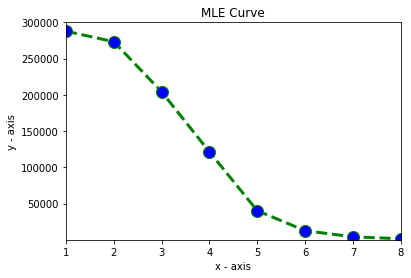

In [ ]:
y = [287847.1813259104,273297.39923557104,204200.18676985777,121342.92803489603,40165.92109969258,12546.646866289433,4126.954545618035,1416.0724907349795,512.5801543141715,193.4222586574033,74.87802619487047,29.394043671898544,11.621602918487042,4.611118729226291,1.8326912447810173,0.7289996570907533,0.2900905515998602,0.11545665003359318,0.04595595924183726,0.018292864318937063,0.007281600032001734,0.0028985771350562572,0.0011538141407072544,0.00045930827036499977]
# corresponding y axis values
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
  
# plotting the points 
plt.plot(x, y, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
  
# setting x and y axis range
plt.ylim(1,300000)
plt.xlim(1,8)
  
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
  
# giving a title to my graph
plt.title('MLE Curve')
  
# function to show the plot
plt.show()

Plotting the Gaussian cluster of the beans on the basis of their shapes

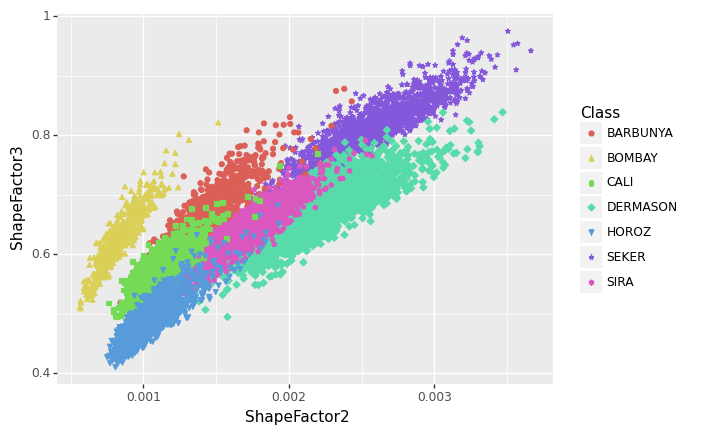

<ggplot: (8746297635762)>

In [ ]:
(ggplot(my_doc, aes(x = "ShapeFactor2",y = "ShapeFactor3",shape = "Class",color = "Class"))+ geom_point())

In [ ]:
z = StandardScaler()
feature = ["MinorAxisLength","MajorAxisLength"]
my_doc = my_doc.head(n=800)
X1 = my_doc[feature]
EM = GMM(n_components = 3)
EM.fit(X1)

GaussianMixture(n_components=3)

Measuring the values of the clusters and the probability distribution of the clusters in a matrix

In [ ]:
cluster = EM.predict(X1)
cluster


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2,
       1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,

In [ ]:
cluster_p = EM.predict_proba(cluster)
cluster_p

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names


ValueError: ignored

In [ ]:
X2=np.array(X1)

Calculating the silhoutte score which describes separation distance between the resulting clusters.


In [ ]:
silhouette_score(X1,cluster)

0.31493240240251424

Calculating adjusted Random Score which computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings

In [ ]:
labels_pred = [173, 182, 175, 182, 190]
labels_true = [208, 200, 212, 210, 201]
metrics.rand_score(labels_pred, labels_true)

0.9